In [1]:
from src.get_from_mongo import get_data
from sklearn.model_selection import train_test_split
from pymongo import MongoClient
import numpy as np
import tensorflow as tf
import pickle

In [2]:
id_from_char = {
    'CAPTAIN_FALCON' : 1 ,
    'DONKEY_KONG'    : 2 ,
    'FOX'            : 3 ,
    'GAME_AND_WATCH' : 4 ,
    'KIRBY'          : 5 ,
    'BOWSER'         : 6 ,
    'LINK'           : 7 ,
    'LUIGI'          : 8 ,
    'MARIO'          : 9 ,
    'MARTH'          : 10 ,
    'MEWTWO'         : 11 ,
    'NESS'           : 12 ,
    'PEACH'          : 13 ,
    'PIKACHU'        : 14 ,
    'ICE_CLIMBERS'   : 15 ,
    'JIGGLYPUFF'     : 16 ,
    'SAMUS'          : 17 ,
    'YOSHI'          : 18 ,
    'ZELDA'          : 19 ,
    'SHEIK'          : 20 ,
    'FALCO'          : 21 ,
    'YOUNG_LINK'     : 22 ,
    'DR_MARIO'       : 23 ,
    'ROY'            : 24 ,
    'PICHU'          : 25 ,
    'GANONDORF'      : 26 ,
}

char_from_id = {v:k for k, v in id_from_char.items()}

In [3]:
database_name = 'slippi'
collection_name = 'melee_clips_30s'

# Connect to the hosted MongoDB instance
client = MongoClient('localhost', 27017)
db = client[database_name]
collection = db[collection_name]

In [4]:
def data_generator(clip_collection=collection, # collection containing clips
                   batch_size = 100,
                   skip=None,
                   step=1,
                   repeat=False,
                   repeat_offset=0):

        cur = clip_collection.find()
        
        if skip:
            cur.skip(skip)
            
        while cur.alive:
            
            xi = []
            yi = []
            
            for _ in range(batch_size):
                
                for _ in range(step):
                    
                    try:
                        clip = next(cur)
                        
                    except StopIteration:
                        if repeat:
                            skip += repeat_offset
                            cur = clip_collection.find()
                            cur.skip(skip)
                            clip = next(cur)
                        else:
                            raise
                            
                xi.append(pickle.loads(clip['istream']).toarray())
                yi.append(id_from_char[clip['character']])

            Xi = np.stack(xi, axis=0)
            Yi = tf.one_hot(yi, 26)

            yield Xi, Yi
            
            

In [5]:
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, InputLayer
from tensorflow.keras.layers import Conv1D, MaxPooling1D

import tensorflow_addons as tfa

top_8_accuracy = keras.metrics.TopKCategoricalAccuracy(k=8)

focal_loss = tfa.losses.SigmoidFocalCrossEntropy()

In [6]:
model = Sequential()

# first conv layer
model.add(Conv1D(100, #num of features extracted from istream
                 30, #number of frames filter can see at once
                 activation='tanh'))

model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(80,
                 30,
                 activation='elu'))

model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(80,
                 30,
                 activation='elu'))

model.add(MaxPooling1D(pool_size=10))

model.add(Flatten())

model.add(Dense(80, activation='elu'))

model.add(Dense(40, activation='elu'))

# final output layer
model.add(Dense(26, activation='softmax'))
                
model.compile(loss=focal_loss,
              optimizer='adam',
              metrics=['accuracy', 'categorical_accuracy', top_8_accuracy])

In [7]:
data = data_generator(batch_size=100, skip=100000, step=5, repeat=True, repeat_offset=1) # keep first 100000 clips as test data

In [8]:
# during fit process watch train and test error simultaneously
model.fit(data, epochs=2, steps_per_epoch=500, verbose=1)

score = model.evaluate(data, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test categorical accuracy: {round(score[2]*100)}%')
print(f'Test test top 8 categorical accuracy: {round(score[3]*100)}%')  # this is the one we care about

Epoch 1/2
500/500 [==============================] - 834s 2s/step - loss: 0.2931 - accuracy: 0.5583 - categorical_accuracy: 0.5583 - top_k_categorical_accuracy: 0.9136
Epoch 2/2
500/500 [==============================] - 834s 2s/step - loss: 0.1907 - accuracy: 0.7275 - categorical_accuracy: 0.7275 - top_k_categorical_accuracy: 0.9402

Test score: 0.17
Test accuracy: 77%
Test categorical accuracy: 77%
Test test top 8 categorical accuracy: 94%


In [40]:
data = data_generator(batch_size=100, skip=100001, step=7, repeat=True, repeat_offset=1) # keep first 100000 clips as test data

In [41]:
# during fit process watch train and test error simultaneously
model.fit(data, epochs=1, steps_per_epoch=500, verbose=1)

score = model.evaluate(data, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test categorical accuracy: {round(score[2]*100)}%')
print(f'Test test top 8 categorical accuracy: {round(score[3]*100)}%')  # this is the one we care about

500/500 [==============================] - 844s 2s/step - loss: 0.1562 - accuracy: 0.7817 - categorical_accuracy: 0.7817 - top_k_categorical_accuracy: 0.9503

Test score: 0.138
Test accuracy: 80%
Test categorical accuracy: 80%
Test test top 8 categorical accuracy: 96%


In [108]:
# during fit process watch train and test error simultaneously
model.fit(data, epochs=1, steps_per_epoch=500, verbose=1)

score = model.evaluate(data, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test categorical accuracy: {round(score[2]*100)}%')
print(f'Test test top 8 categorical accuracy: {round(score[3]*100)}%')  # this is the one we care about

500/500 [==============================] - 846s 2s/step - loss: 0.1293 - accuracy: 0.8138 - categorical_accuracy: 0.8138 - top_k_categorical_accuracy: 0.9570

Test score: 0.107
Test accuracy: 84%
Test categorical accuracy: 84%
Test test top 8 categorical accuracy: 96%


In [109]:
# during fit process watch train and test error simultaneously
model.fit(data, epochs=1, steps_per_epoch=500, verbose=1)

score = model.evaluate(data, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test categorical accuracy: {round(score[2]*100)}%')
print(f'Test test top 8 categorical accuracy: {round(score[3]*100)}%')  # this is the one we care about

500/500 [==============================] - 858s 2s/step - loss: 0.1122 - accuracy: 0.8371 - categorical_accuracy: 0.8371 - top_k_categorical_accuracy: 0.9625

Test score: 0.128
Test accuracy: 81%
Test categorical accuracy: 81%
Test test top 8 categorical accuracy: 96%


In [11]:
def get_conf_matrix(labels_as_id, predictions_as_id):
    conf_matrix = np.zeros((27,27))
    for i_real, i_pred in zip(labels_as_id, predictions_as_id):
        conf_matrix[i_real, i_pred] += 1
    return conf_matrix

In [42]:
X_test, Y_test = next(data_generator(batch_size=5000, step = 5))

In [43]:
pred = np.argmax(model.predict(X_test), axis = 1)
y_test = np.argmax(Y_test, axis = 1)

In [44]:
score = model.evaluate(X_test, Y_test, verbose=0)

In [45]:
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 categorical accuracy: {round(score[3]*100)}%') 


Test score: 0.137
Test accuracy: 80%
Test test top 8 categorical accuracy: 96%


In [48]:
recalls = {k:0 for k in range(1,27)}
precisions = {k:0 for k in range(1,27)}
conf_matrix = get_conf_matrix(y_test, pred)
char_id = 0

In [76]:
char_id += 1
row = conf_matrix[char_id, :]
sorted_row_indices = np.argsort(row)[::-1]
correct = conf_matrix[char_id, char_id]
total = np.sum(row)
recall = correct/total if total else 0
recalls[char_id] = recall
print(f'{char_from_id[char_id]}')
print(f'Recall: {round(100*recall, 1)}%\n ------------------')
for i in sorted_row_indices:
    if i > 0:
        print(f'{char_from_id[i]} : {row[i]}')

GANONDORF
Recall: 0%
 ------------------
GANONDORF : 0.0
NESS : 0.0
CAPTAIN_FALCON : 0.0
DONKEY_KONG : 0.0
FOX : 0.0
GAME_AND_WATCH : 0.0
KIRBY : 0.0
BOWSER : 0.0
LINK : 0.0
LUIGI : 0.0
MARIO : 0.0
MARTH : 0.0
MEWTWO : 0.0
PEACH : 0.0
PICHU : 0.0
PIKACHU : 0.0
ICE_CLIMBERS : 0.0
JIGGLYPUFF : 0.0
SAMUS : 0.0
YOSHI : 0.0
ZELDA : 0.0
SHEIK : 0.0
FALCO : 0.0
YOUNG_LINK : 0.0
DR_MARIO : 0.0
ROY : 0.0


In [77]:
for i, acc in {k: v for k, v in sorted(recalls.items(), key=lambda item: -item[1])}.items():
    print(f'{char_from_id[i]}:\t{round(100*acc, 1)}%')

PEACH:	93.2%
FOX:	92.4%
MARTH:	91.0%
FALCO:	88.5%
SHEIK:	83.5%
CAPTAIN_FALCON:	79.3%
SAMUS:	72.9%
JIGGLYPUFF:	72.3%
YOSHI:	54.5%
ICE_CLIMBERS:	36.7%
PIKACHU:	23.1%
LUIGI:	13.2%
NESS:	12.5%
ZELDA:	11.4%
LINK:	4.2%
DONKEY_KONG:	0.0%
GAME_AND_WATCH:	0.0%
KIRBY:	0.0%
BOWSER:	0.0%
MARIO:	0.0%
MEWTWO:	0.0%
YOUNG_LINK:	0.0%
DR_MARIO:	0.0%
ROY:	0.0%
PICHU:	0.0%
GANONDORF:	0%


In [78]:
char_id = 0

In [105]:
char_id += 1
col = conf_matrix[:, char_id]
sorted_col_indices = np.argsort(col)[::-1]
correct = conf_matrix[char_id, char_id]
total = np.sum(col)
precision = correct/total if total else 0
precisions[char_id] = precision
print(f'{char_from_id[char_id]}')
print(f'Precision: {round(100*precision, 1)}%\n ------------------')
for i in sorted_col_indices:
    if i > 0:
        print(f'{char_from_id[i]} : {col[i]}')

IndexError: index 27 is out of bounds for axis 1 with size 27

In [107]:
for i, acc in {k: v for k, v in sorted(precisions.items(), key=lambda item: -item[1])}.items():
    print(f'{char_from_id[i]}:\t{round(100*acc, 1)}%')

FALCO:	95.8%
PEACH:	94.4%
FOX:	90.0%
PIKACHU:	88.2%
CAPTAIN_FALCON:	85.0%
YOSHI:	83.7%
ICE_CLIMBERS:	76.6%
SAMUS:	67.7%
SHEIK:	65.3%
MARTH:	61.5%
JIGGLYPUFF:	51.3%
NESS:	50.0%
ZELDA:	40.0%
LUIGI:	36.8%
LINK:	33.3%
DONKEY_KONG:	0.0%
GAME_AND_WATCH:	0%
KIRBY:	0%
BOWSER:	0%
MARIO:	0.0%
MEWTWO:	0%
YOUNG_LINK:	0%
DR_MARIO:	0.0%
ROY:	0%
PICHU:	0%
GANONDORF:	0%


In [123]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 100)         39100     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 100)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 80)          240080    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 80)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 80)          192080    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 80)          0         
_________________________________________________________________
flatten (Flatten)            (None, None)              0

In [22]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [49]:
conf_df = pd.DataFrame(conf_matrix[1:, 1:], index=id_from_char.keys(), columns=id_from_char.keys())

<AxesSubplot:>

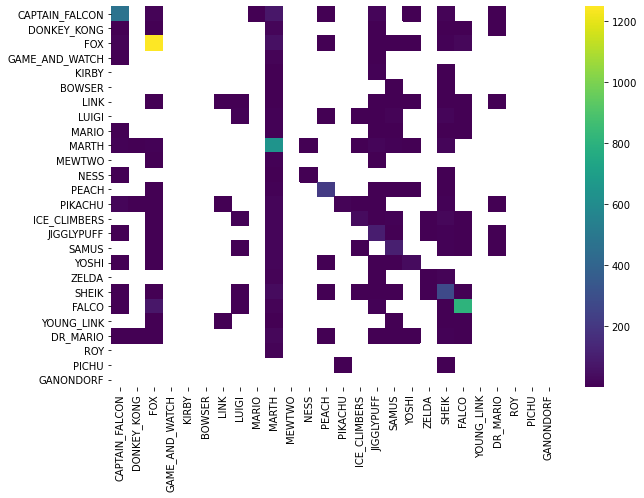

In [50]:
plt.figure(figsize = (10,7))
sn.heatmap(conf_df, annot=False, mask = conf_df <= 0, cmap='viridis')